## Project (Shiller Investment Dataset)

### Outline  
1. Import Data  
2. Process Data  
a. Feedforward Dataset  
b. LSTM Dataset  
3. Generate Expected Returns and Risks  
a. Linear Regression Factor Model  
b. Feedforward Factor Model  
c. CNN + LSTM Factor Model  
d. Generate Expected Risks   
e. Determine SAA Portfolio from Training Dataset   
4. Generate Portfolio Weights - Relative Optimization  
a. Linear Regression TAA Overlay  
b. Feedforward TAA Overlay  
c. CNN + LSTM TAA Overlay  
5. Calculate TAA Portfolio Returns  
a. Linear Regression TAA Overlay  
b. Feedforward TAA Overlay  
c. CNN + LSTM TAA Overlay     
6. Compare Performance  
a. Results For "Out of Sample" (test dataset)  
b. Results For "In Sample" (train dataset)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Conv2D
from tensorflow.keras.layers import Dropout, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [5]:
import scipy.stats as sp

## 1. Import Data

### <font color='blue'>*Import Data functions*</font>

In [6]:
def import_data():
    # Creates dataFrame for feed forward model
    df = pd.read_pickle("df_shiller")  # pandas dataframe
    df.Stk_ret = df.Stk_ret.shift(-1)
    df.Bnd_ret = df.Bnd_ret.shift(-1)
    df.dropna(inplace=True)
    return df

In [7]:
def import_data_lstm():
    # Creates dataFrame for LSTM model
    df = pd.read_pickle("df_shiller")  # pandas dataframe
    df.dropna(inplace=True)
    return df

#### Import data

In [8]:
start_date = '1920-12-31'

In [9]:
df = import_data()
df = df.loc[df.index > start_date]
df.head()

,Stk_ret,Bnd_ret,Value,Momentum_stk,Momentum_bnd,Growth,Yield
Date,,,,,,,
1924-12-31,0.045884,0.004527,0.091535,0.261498,0.057413,0.000000,0.038767
1925-01-31,0.012904,0.004379,0.090425,0.271165,0.056547,0.008029,0.038600
1925-02-28,-0.021849,0.004368,0.092156,0.275372,0.056249,0.015994,0.038450
1925-03-31,-0.006042,0.004357,0.097209,0.265398,0.055953,0.023900,0.038300
1925-04-30,0.036728,0.004345,0.100875,0.280609,0.055658,0.031812,0.038150


In [10]:
df_lstm = import_data_lstm()
df_lstm = df_lstm.loc[df_lstm.index > start_date]
df_lstm.head()

,Stk_ret,Bnd_ret,Value,Momentum_stk,Momentum_bnd,Growth,Yield
Date,,,,,,,
1924-12-31,0.058696,0.004539,0.091535,0.261498,0.057413,0.000000,0.038767
1925-01-31,0.045884,0.004527,0.090425,0.271165,0.056547,0.008029,0.038600
1925-02-28,0.012904,0.004379,0.092156,0.275372,0.056249,0.015994,0.038450
1925-03-31,-0.021849,0.004368,0.097209,0.265398,0.055953,0.023900,0.038300
1925-04-30,-0.006042,0.004357,0.100875,0.280609,0.055658,0.031812,0.038150


In [11]:
df_lstm.describe().T

,count,mean,std,min,25%,50%,75%,max
Stk_ret,1165.0,0.009432,0.044423,-0.261879,-0.009918,0.012961,0.032561,0.513085
Bnd_ret,1165.0,0.004142,0.015248,-0.080542,-0.001424,0.002906,0.009154,0.105548
Value,1165.0,0.069624,0.028530,0.008082,0.051409,0.060862,0.086094,0.171797
Momentum_stk,1165.0,0.126156,0.204124,-0.622834,0.007803,0.136464,0.252546,1.398059
Momentum_bnd,1165.0,0.051994,0.072471,-0.113205,0.014542,0.037885,0.077057,0.424480
Growth,1165.0,0.059567,0.102995,-0.333095,0.016012,0.059964,0.099845,0.711868
Yield,1165.0,0.047992,0.027953,0.006200,0.026342,0.038600,0.064800,0.153200


# 2. Process Data

## 2a. Feedforward Dataset

#### Split data

In [12]:
X = df.iloc[:,2:]         # factors
y = df.iloc[:,:2]         # returns

fraction_test = 0.2       # fraction of total dataset that is used for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=fraction_test, shuffle=False)

#### Scale Data

In [13]:
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


In [14]:
X_train_scaled.mean(axis=0)

array([ 4.88450431e-16,  3.24361614e-17, -6.10563038e-17,  1.52640760e-17,
       -1.22112608e-16])

## 2b. CNN and LSTM Dataset

#### Create Sequences

In [15]:
X_lstm = []
y_lstm_stk = []
y_lstm_bnd = []
win_len = 12
num_factors = df.shape[1]
for i in range(win_len, len(df)):
    X_lstm.append(df.iloc[i-win_len:i,2:])
    y_lstm_stk.append(df.iloc[i,0])
    y_lstm_bnd.append(df.iloc[i,1])

#### Convert to Numpy arrays

In [16]:
X_lstm, y_lstm_stk, y_lstm_bnd = np.array(X_lstm), np.array(y_lstm_stk), np.array(y_lstm_bnd)

In [17]:
y_lstm_stk = y_lstm_stk.reshape(-1,1)
y_lstm_bnd = y_lstm_bnd.reshape(-1,1)

In [18]:
X_lstm.shape

(1152, 12, 5)

In [19]:
y_lstm_stk.shape

(1152, 1)

#### Split data

In [20]:
fraction_test = 0.2  # fraction of total dataset that is used for testing
X_train_lstm, X_test_lstm, y_train_lstm_stk, y_test_lstm_stk, y_train_lstm_bnd, y_test_lstm_bnd = train_test_split(
    X_lstm, y_lstm_stk, y_lstm_bnd, test_size=fraction_test, shuffle=False)

#### Scale Data

In [21]:
scaler_X_lstm = StandardScaler()

X_train_lstm_scaled = scaler_X_lstm.fit_transform(
    X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_test_lstm_scaled = scaler_X_lstm.transform(
    X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)

# 3. Generate Expected Returns and Risks

## 3a. Linear regression model

### Linear regression model for stock returns

In [22]:
model_stk_reg = LinearRegression()

In [23]:
reg_stk = model_stk_reg.fit(X_train_scaled, y_train['Stk_ret'])

Coefficients

In [24]:
reg_stk.coef_

array([ 0.0063019 ,  0.0051174 ,  0.0055881 , -0.00145633, -0.00221203])

Intercept

In [25]:
reg_stk.intercept_

0.00939240462205837

#### Generate expected returns for stocks

In [26]:
y_train['Stk_ret_reg'] = reg_stk.predict(X_train_scaled)
y_test['Stk_ret_reg'] = reg_stk.predict(X_test_scaled)

<ipython-input-26-bf54e1584d76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_ret_reg'] = reg_stk.predict(X_train_scaled)
<ipython-input-26-bf54e1584d76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_ret_reg'] = reg_stk.predict(X_test_scaled)


#### Evaluate accuracy

In [27]:
print("The R-Square on the Train set is:\t{:0.3f}".format(r2_score(y_train['Stk_ret'], y_train['Stk_ret_reg'])))
print("The R-Square on the Test set is:\t{:0.3f}".format(r2_score(y_test['Stk_ret'], y_test['Stk_ret_reg'])))

The R-Square on the Train set is:	0.035
The R-Square on the Test set is:	-0.033


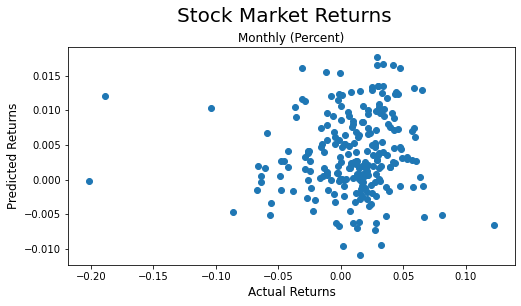

In [28]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Stk_ret'], y_test['Stk_ret_reg'])
plt.suptitle('Stock Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

### Linear regression model for bond returns

In [29]:
model_bnd_reg = LinearRegression()

In [30]:
reg_bnd = model_bnd_reg.fit(X_train_scaled, y_train['Bnd_ret'])

Coefficients

In [31]:
reg_bnd.coef_

array([ 0.0001087 , -0.0011193 ,  0.00177348, -0.00014315,  0.00244546])

Intercept

In [32]:
reg_bnd.intercept_

0.004261369157107023

#### Generate expected returns for bonds

In [33]:
y_train['Bnd_ret_reg'] = reg_bnd.predict(X_train_scaled)
y_test['Bnd_ret_reg'] = reg_bnd.predict(X_test_scaled)

<ipython-input-33-fc5886cf76f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Bnd_ret_reg'] = reg_bnd.predict(X_train_scaled)
<ipython-input-33-fc5886cf76f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Bnd_ret_reg'] = reg_bnd.predict(X_test_scaled)


#### Evaluate accuracy

In [34]:
print("The R-Square on the Train set is:\t{:0.3f}".format(r2_score(y_train['Bnd_ret'], y_train['Bnd_ret_reg'])))
print("The R-Square on the Test set is:\t{:0.3f}".format(r2_score(y_test['Bnd_ret'], y_test['Bnd_ret_reg'])))

The R-Square on the Train set is:	0.057
The R-Square on the Test set is:	-0.004


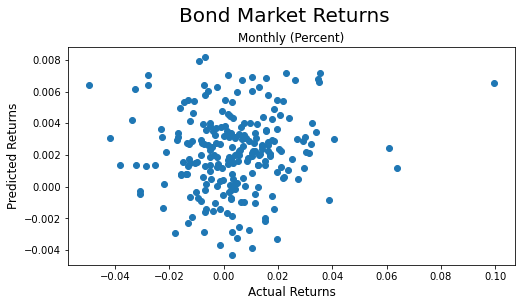

In [35]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Bnd_ret'], y_test['Bnd_ret_reg'])
plt.suptitle('Bond Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

## 3b. Feedforward Neural Network

####  <font color='blue'>*Feed Forward Model function*</font>

In [42]:
def feed_forward_model(X_train, y_train, learning_rate, epochs):
    # Model structure
    model = Sequential()
    model.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1,))
    # Compile model
    model.compile(Adam(learning_rate=learning_rate), 'mean_squared_error')
    # Train (fit) model
    history = model.fit(X_train, y_train, 
                    epochs = epochs, 
                    validation_split = 0.2,
                    verbose = 0)
    return model, history

### Feed Forward model for stock returns

In [43]:
learning_rate=0.001 
epochs=100
model_stk_dl, history = feed_forward_model(X_train_scaled, y_train.Stk_ret, learning_rate, epochs)

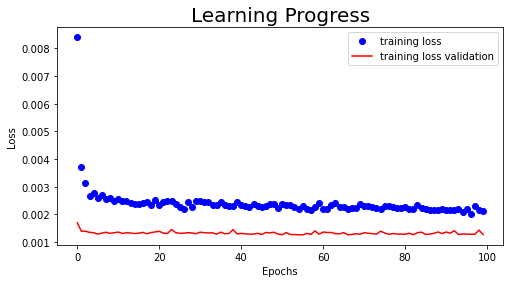

In [44]:
# Plot of learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for stocks

In [45]:
y_train['Stk_ret_dl'] = model_stk_dl.predict(X_train_scaled)
y_test['Stk_ret_dl'] = model_stk_dl.predict(X_test_scaled)

8/8 [==============================] - 0s 2ms/step


<ipython-input-45-284bdb0d5135>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_ret_dl'] = model_stk_dl.predict(X_train_scaled)
<ipython-input-45-284bdb0d5135>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_ret_dl'] = model_stk_dl.predict(X_test_scaled)


#### Evaluate accuracy

In [46]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train['Stk_ret'], y_train['Stk_ret_dl'])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test['Stk_ret'], y_test['Stk_ret_dl'])))

The R2 score on the Train set is:	0.113
The R2 score on the Test set is:	-0.726


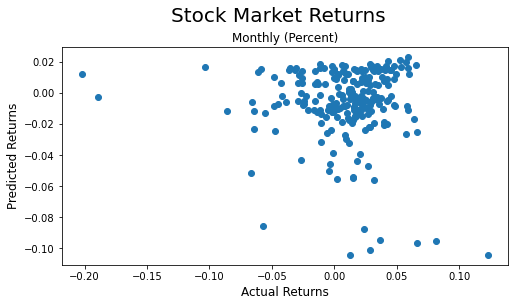

In [47]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Stk_ret'], y_test['Stk_ret_dl'])
plt.suptitle('Stock Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

### Feed Forward model for bond returns

In [48]:
model_bnd_dl, history = feed_forward_model(X_train_scaled, y_train.Bnd_ret, learning_rate=learning_rate, epochs=epochs)

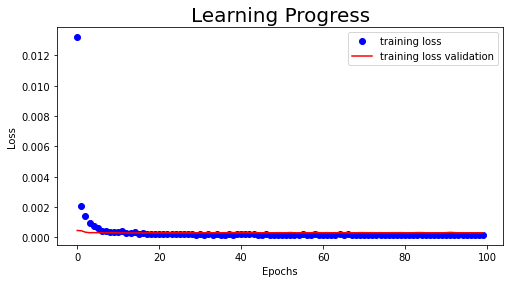

In [49]:
# Plots learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for bonds

In [50]:
y_train['Bnd_ret_dl'] = model_bnd_dl.predict(X_train_scaled)
y_test['Bnd_ret_dl'] = model_bnd_dl.predict(X_test_scaled)


8/8 [==============================] - 0s 2ms/step


<ipython-input-50-7387e72a8c6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Bnd_ret_dl'] = model_bnd_dl.predict(X_train_scaled)
<ipython-input-50-7387e72a8c6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Bnd_ret_dl'] = model_bnd_dl.predict(X_test_scaled)


#### Evaluate accuracy

In [51]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train['Bnd_ret'], y_train['Bnd_ret_dl'])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test['Bnd_ret'], y_test['Bnd_ret_dl'])))

The R2 score on the Train set is:	0.065
The R2 score on the Test set is:	-0.001


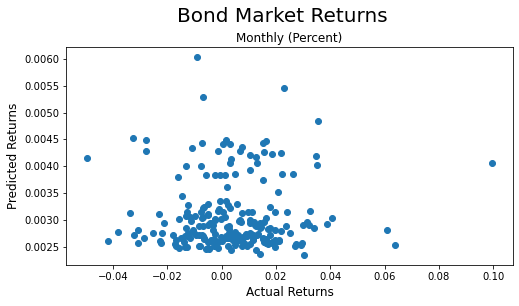

In [52]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Bnd_ret'], y_test['Bnd_ret_dl'])
plt.suptitle('Bond Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

## 3c. CNN + LSTM models

#### <font color='blue'>*CNN Model function*</font>

In [59]:
def cnn_model(X_train, y_train, learning_rate, epochs):
    # Model structure   
    model = Sequential()
    
    # CNN
    model.add(Conv1D(filters=128, kernel_size=3, dilation_rate=2,
                         activation='relu', input_shape=(win_len, num_factors-2)))
    model.add(Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(0.3))
    
    # LSTM
    model.add(LSTM(25, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Flatten())
    
    # Feed Forward
    model.add(Dense(1))
    
    # Compile model
    model.compile(Adam(learning_rate=learning_rate), 'mse')
    
    # Train (fit) model
    history = model.fit(X_train, y_train, 
                    epochs = epochs, 
                    validation_split = 0.2,
                    verbose = 0)
    return model, history

### CNN + LSTM model for stock returns

In [60]:
learning_rate=0.001
epochs=150

model_lstm_stk, history = cnn_model(X_train_lstm_scaled, y_train_lstm_stk, learning_rate, epochs)

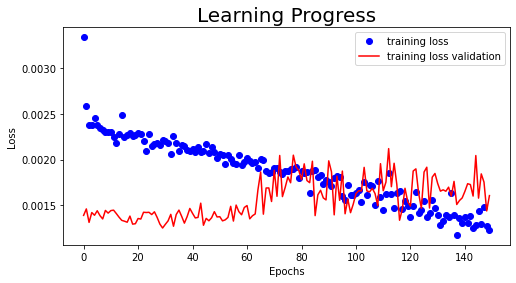

In [61]:
# Plots learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for stocks

In [62]:
y_train_lstm_stk_pred = model_lstm_stk.predict(X_train_lstm_scaled)
y_test_lstm_stk_pred = model_lstm_stk.predict(X_test_lstm_scaled)

8/8 [==============================] - 0s 3ms/step


#### Evaluate accuracy

In [63]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_lstm_stk, y_train_lstm_stk_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_lstm_stk, y_test_lstm_stk_pred)))

The R2 score on the Train set is:	0.527
The R2 score on the Test set is:	-0.252


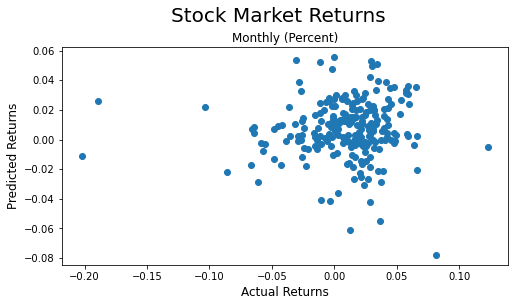

In [64]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test_lstm_stk, y_test_lstm_stk_pred)
plt.suptitle('Stock Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

### Pure LSTM model for bond returns

In [65]:
def lstm_model_bond(X_train, y_train, learning_rate, epochs):
    # Model structure   
    model = Sequential()
    model.add(LSTM(50, input_shape= (win_len, num_factors-2), activation='relu', return_sequences=True))
    model.add(Dropout(0.3))  
    model.add(LSTM(25, activation='relu', return_sequences=False))
    model.add(Dense(1))
    
    # Compile model
    model.compile(Adam(learning_rate=learning_rate), 'mse')
    
    # Train (fit) model
    history = model.fit(X_train, y_train, 
                    epochs = epochs, 
                    validation_split = 0.2,
                    verbose = 0)
    return model, history

In [66]:
learning_rate=0.001
epochs=150
model_lstm_bnd, history = lstm_model_bond(X_train_lstm_scaled, y_train_lstm_bnd, learning_rate, epochs)

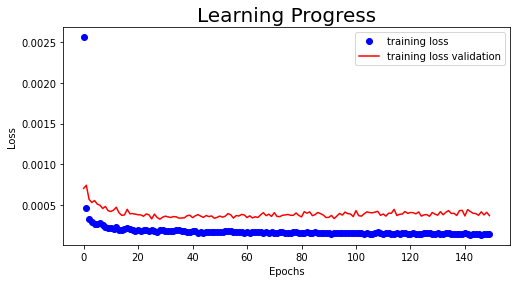

In [67]:
# Plots learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for bonds

In [69]:
y_train_lstm_bnd_pred = model_lstm_bnd.predict(X_train_lstm_scaled)
y_test_lstm_bnd_pred = model_lstm_bnd.predict(X_test_lstm_scaled)

8/8 [==============================] - 0s 6ms/step


#### Evaluate accuracy

In [70]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_lstm_bnd, y_train_lstm_bnd_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_lstm_bnd, y_test_lstm_bnd_pred)))

The R2 score on the Train set is:	0.160
The R2 score on the Test set is:	-0.060


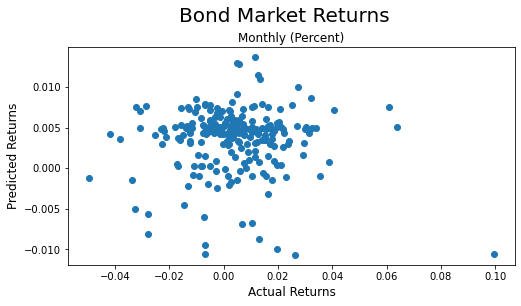

In [71]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test_lstm_bnd, y_test_lstm_bnd_pred)
plt.suptitle('Bond Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

## 3d. Generate Expected Risks

In [72]:
# Standard deviations
stk_risk = np.std(y_train.Stk_ret)
bnd_risk = np.std(y_train.Bnd_ret)
print(f'stk risk = {stk_risk:.2%}')
print(f'bnd risk = {bnd_risk:.2%}')

stk risk = 4.63%
bnd risk = 1.46%


In [73]:
# Correlation
stk_bnd_corr = np.corrcoef(y_train.Stk_ret, y_train.Bnd_ret)
stk_bnd_corr = stk_bnd_corr[0,1]
stk_bnd_corr
print(f'stock-bond correlation = {stk_bnd_corr:.3f}')

stock-bond correlation = 0.104


## 3e. Determine SAA Portfolio from Training Dataset

In [107]:
# Capital Market Assumptions (CMAs) -- using training dataset

stk_ret = np.mean(y_train.Stk_ret)
bnd_ret = np.mean(y_train.Bnd_ret)

In [108]:
# Determine Optimal SAA Portfolio Weights

risk_tol = 0.4

stk_wgt = (risk_tol*(stk_ret-bnd_ret) + bnd_risk**2 - stk_risk*bnd_risk*stk_bnd_corr
          )/(stk_risk**2 + bnd_risk**2 - 2*stk_risk*bnd_risk*stk_bnd_corr)

bnd_wgt = 1-stk_wgt
total_wgt = stk_wgt + bnd_wgt

print(f'Optimal portfolio weight for stocks = {stk_wgt:.2%}')
print(f'Optimal portfolio weight for bonds = {bnd_wgt:.2%}')
print(f'Total = {total_wgt:.2%}')

Optimal portfolio weight for stocks = 97.01%
Optimal portfolio weight for bonds = 2.99%
Total = 100.00%


# 4. Generate Portfolio Weights - Relative Optimization

### Relative Optimization Function

In [74]:
def relative_optimizer(stk_alpha, bnd_alpha, stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol = .10):
    # Caluculate optimal stock weight
    stk_dwgt = rel_risk_tol*(stk_alpha-bnd_alpha)/(stk_risk**2 + bnd_risk**2 - 2*stk_risk*bnd_risk*stk_bnd_corr)
    # Bond weight
    bnd_dwgt = -stk_dwgt
    return stk_dwgt, bnd_dwgt

### 4a. Linear Regression TAA Overlay

#### *Stock weights for train dataset*

In [75]:
rel_risk_tol = .1
y_train['Stk_dwgt_reg'], y_train['Bnd_dwgt_reg'] = relative_optimizer(y_train.Stk_ret_reg, y_train.Bnd_ret_reg, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-75-3b5c284d31b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_dwgt_reg'], y_train['Bnd_dwgt_reg'] = relative_optimizer(y_train.Stk_ret_reg, y_train.Bnd_ret_reg,


<AxesSubplot:xlabel='Date'>

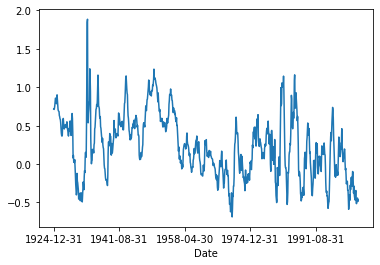

In [76]:
y_train.Stk_dwgt_reg.plot()

#### *Stock weights for test dataset*

In [77]:
y_test['Stk_dwgt_reg'], y_test['Bnd_dwgt_reg'] = relative_optimizer(y_test.Stk_ret_reg, y_test.Bnd_ret_reg, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-77-3d8d9db46c0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_dwgt_reg'], y_test['Bnd_dwgt_reg'] = relative_optimizer(y_test.Stk_ret_reg, y_test.Bnd_ret_reg,


<AxesSubplot:xlabel='Date'>

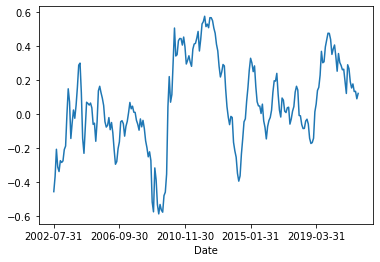

In [78]:
y_test.Stk_dwgt_reg.plot()

### 4b. Feedforward TAA Overlay

#### *Stock weights for train dataset*

In [79]:
rel_risk_tol = .1
y_train['Stk_dwgt_dl'], y_train['Bnd_dwgt_dl'] = relative_optimizer(y_train.Stk_ret_dl, y_train.Bnd_ret_dl, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-79-08c08c1b1efa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_dwgt_dl'], y_train['Bnd_dwgt_dl'] = relative_optimizer(y_train.Stk_ret_dl, y_train.Bnd_ret_dl,


<AxesSubplot:xlabel='Date'>

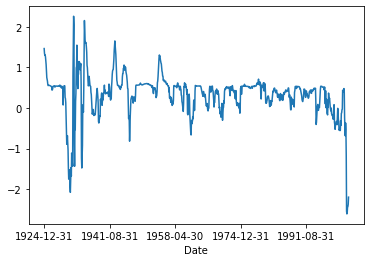

In [80]:
y_train.Stk_dwgt_dl.plot()

#### *Stock weights for test dataset*

In [81]:
y_test['Stk_dwgt_dl'], y_test['Bnd_dwgt_dl'] = relative_optimizer(y_test.Stk_ret_dl, y_test.Bnd_ret_dl, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-81-f9e1c21702ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_dwgt_dl'], y_test['Bnd_dwgt_dl'] = relative_optimizer(y_test.Stk_ret_dl, y_test.Bnd_ret_dl,


<AxesSubplot:xlabel='Date'>

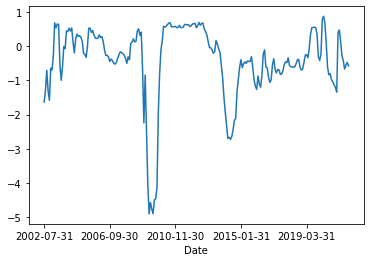

In [82]:
y_test.Stk_dwgt_dl.plot()

### 4c. CNN + LSTM TAA Overlay

#### *Stock weights for train dataset*

In [83]:
rel_risk_tol = .1
y_train_lstm_stk_dwgt, y_train_lstm_bnd_dwgt = relative_optimizer(y_train_lstm_stk_pred, y_train_lstm_bnd_pred, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

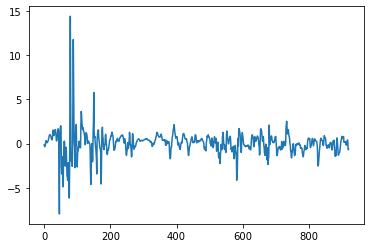

In [84]:
plt.plot(y_train_lstm_stk_dwgt)

#### *Stock weights for test dataset*

In [85]:
y_test_lstm_stk_dwgt, y_test_lstm_bnd_dwgt = relative_optimizer(y_test_lstm_stk_pred, y_test_lstm_bnd_pred, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

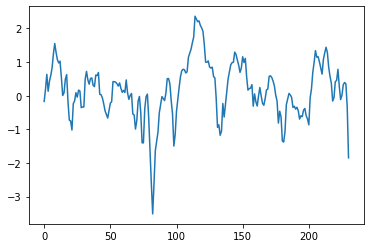

In [86]:
plt.plot(y_test_lstm_stk_dwgt)

# 5. Calculate TAA Portfolio Returns

### 5a. Linear Regression TAA Overlay

#### *Portfolio returns for train dataset*

In [87]:
y_train['Port_ret_reg'] = y_train.Stk_dwgt_reg*y_train.Stk_ret + y_train.Bnd_dwgt_reg*y_train.Bnd_ret

<ipython-input-87-d573ee69c1a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Port_ret_reg'] = y_train.Stk_dwgt_reg*y_train.Stk_ret + y_train.Bnd_dwgt_reg*y_train.Bnd_ret


#### *Portfolio returns for test dataset*

In [88]:
y_test['Port_ret_reg'] = y_test.Stk_dwgt_reg*y_test.Stk_ret + y_test.Bnd_dwgt_reg*y_test.Bnd_ret

<ipython-input-88-c5fafc5bc7dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Port_ret_reg'] = y_test.Stk_dwgt_reg*y_test.Stk_ret + y_test.Bnd_dwgt_reg*y_test.Bnd_ret


### 5b. Feedforward TAA Overlay

#### *Portfolio returns for train dataset*

In [89]:
y_train['Port_ret_dl'] = y_train.Stk_dwgt_dl*y_train.Stk_ret + y_train.Bnd_dwgt_dl*y_train.Bnd_ret

<ipython-input-89-4d894de246d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Port_ret_dl'] = y_train.Stk_dwgt_dl*y_train.Stk_ret + y_train.Bnd_dwgt_dl*y_train.Bnd_ret


#### *Portfolio returns for test dataset*

In [90]:
y_test['Port_ret_dl'] = y_test.Stk_dwgt_dl*y_test.Stk_ret + y_test.Bnd_dwgt_dl*y_test.Bnd_ret

<ipython-input-90-9b8f16de6ee8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Port_ret_dl'] = y_test.Stk_dwgt_dl*y_test.Stk_ret + y_test.Bnd_dwgt_dl*y_test.Bnd_ret


### 5c. CNN + LSTM TAA Overlay

#### *Portfolio returns for train dataset*

In [91]:
y_train_lstm_port = y_train_lstm_stk_dwgt*y_train_lstm_stk + y_train_lstm_bnd_dwgt*y_train_lstm_bnd

#### *Portfolio returns for test dataset*

In [92]:
y_test_lstm_port = y_test_lstm_stk_dwgt*y_test_lstm_stk + y_test_lstm_bnd_dwgt*y_test_lstm_bnd

# 6. Compare Performance

#### <font color='blue'>*Performance Measurement function*</font>

In [93]:
def perform_measure(df_returns):
    df_results = df_returns.describe().transpose()[['mean', 'std']]
    df_results['Info Ratio (IR)'] = (df_results['mean']/df_results['std'])
    df_results['geomean'] = sp.gmean(df_returns+1)-1
    
    return df_results

## 6a. Results For "Out of Sample" (test dataset)

In [94]:
# Align test dataset length with lstm returns length
diff  = y_test.shape[0] - y_test_lstm_port.shape[0]
y_test = y_test.iloc[diff:,:]

In [95]:
# Add lstm returns to y_test datafrane
y_test['Port_ret_lstm'] = y_test_lstm_port

In [97]:
y_test_returns = y_test[['Port_ret_lstm', 'Port_ret_dl', 'Port_ret_reg', 'Stk_ret', 'Bnd_ret']]

y_test_results = perform_measure(y_test_returns)

In [98]:
y_test_results

,mean,std,Info Ratio (IR),geomean
Port_ret_lstm,0.000972,0.039335,0.024702,0.000144
Port_ret_dl,-0.006844,0.069433,-0.098573,-0.010256
Port_ret_reg,0.001432,0.015831,0.090480,0.001305
Stk_ret,0.009618,0.035991,0.267242,0.008946
Bnd_ret,0.003393,0.017451,0.194433,0.003243


In [99]:
y_test_cumrets = (1+y_test_returns).cumprod()

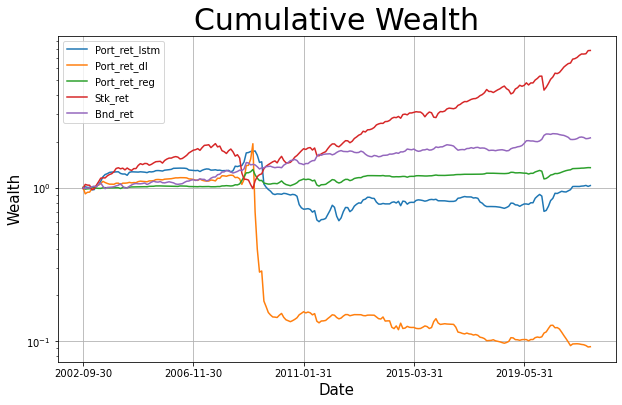

In [100]:
y_test_cumrets.plot(logy=True, figsize=(10,6))
plt.title('Cumulative Wealth', fontsize = 30)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Wealth', fontsize = 15)
plt.grid()

## 6b. Results For "In Sample" (train dataset)

In [101]:
# Align train dataset length with lstm returns length
diff  = y_train.shape[0] - y_train_lstm_port.shape[0]
y_train = y_train.iloc[diff:,:]

In [102]:
# Add lstm returns to y_test datafrane
y_train['Port_ret_lstm'] = y_train_lstm_port

In [103]:
y_train_returns = y_train[['Port_ret_lstm', 'Port_ret_dl', 'Port_ret_reg', 'Stk_ret', 'Bnd_ret']]

y_train_results = perform_measure(y_train_returns)

In [104]:
y_train_results

,mean,std,Info Ratio (IR),geomean
Port_ret_lstm,0.044244,0.293418,0.150787,0.031703
Port_ret_dl,0.010319,0.051151,0.201744,0.009306
Port_ret_reg,0.004767,0.021160,0.225295,0.004547
Stk_ret,0.009272,0.046487,0.199449,0.008209
Bnd_ret,0.004260,0.014691,0.290007,0.004154


In [105]:
y_train_cumrets = (1+y_train_returns).cumprod()

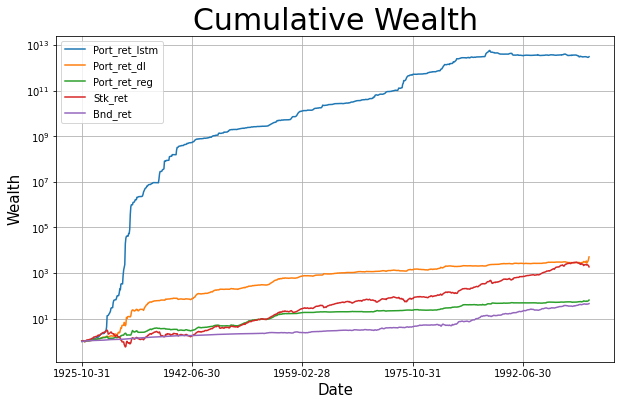

In [106]:
y_train_cumrets.plot(logy=True, figsize=(10,6))
plt.title('Cumulative Wealth', fontsize = 30)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Wealth', fontsize = 15)
plt.grid()